# Simple Machine-Learning: Boosted Regression Predictions
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 19, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/BRT_2D.ipynb

>📘 Learning Objectives
>
> 1. Understand the basics of prediction
> 2. Learn the format that your training data should be in
> 3. Learn to fit a Boosted Regression Tree
> 4. Evaluate fit
> 5. Make predictions with your model

::: {.callout-important}
# Important notes for this tutorial

### The functions are in a separate file

The Python functions for doing tasks, like prepping the data and plotting, are in a separate file `ml_utils.py` and the functions are imported with `import ml_utils as mu`. You will need to run the import code to have access to the functions.
:::

## Summary

In this tutorial we will predict a numerical variable (chl) using predictor variables, in this case hyperspectral Rrs and solar hour. Later we can add location and season. Our end goal is to create global maps of CHLA vertical profiles using Rrs hyperspectral data. CHLA vertical profiles are key to research on subsurface chlorophyll maxima, bloom structure, diel variability, and vertical migration.

Our training data are the in-situ measurements of surface CHLA from Bio-Argo buoys. You can see how we downloaded the Argo data and got the PACE Rrs matchups in the files `argopy.ipnb` and `argopy-matchups.ipynb`.

$$
\hat{y} \sim f(Rrs, \text{solar hour})
$$

We will use a classic non-linear prediction model: boosted regression trees (BRTs). Trees learn a big collection of if-else rules that split the response variable space. BRTs are non-linear: they can learn complicated non-linear relationships.

The goal is to create a predicted map of CHL at depths 0 to 200m in 10m bins given our Rrs predictor variables on a given day.

## Overview of the modeling steps

1. Create your sampling dataframe: spatial samples with response (what you are trying to predict), latitude, longitude, date.
2. Create your predictor dataframe. In this example we have an 3D cube (time, lat, lon) with all the Rrs, location and season variables and we sample from that.
3. Fit model
5. Make predictions

The hard part is the data prep. We need a dataframe that looks like this. Just showing the first 5 samples. `y` is what we are predicting and it is the true values we have (from some type of observation) and the variables to the right are what we train on. The ocean mask just tells up what to ignore (it's land).

| time       | lat   | lon   | y      | Rrs_370 | Rrs_400 | solar_hour |
| ---------- | ----- | ----- | ------ | ------- | ------- | ---------- |
| 2020-07-03 | 12.25 | 63.50 | -1.273 | 27.84   | 34.82   | 1          | 
| 2020-01-15 | 28.75 | 74.25 | -0.522 | 24.11   | 35.21   | 1          |
| 2020-03-28 | -2.00 | 88.75 | -2.004 | 29.47   | 34.55   | 8          |
| 2020-10-09 | 5.75  | 59.25 | -1.618 | 26.33   | 34.90   | 10         |
| 2020-12-22 | 17.50 | 46.50 | -0.931 | 22.88   | 35.40   | 23         |


## Variables in the model

A nice thing about BRTs is that we do not need to normalize (standardize) our predictor variables. BRTs work by splitting our predictors and normalizing has no effect. This is different than many other types of models that will perform much better with normalization.

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `Rrs_wav`     | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric                |
| `solar_hour` | ❌ Same across lat/lon   | ✅ Varies by time   | Hour |
| `y` (log CHL) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric  |


- **`Rrs`**: Hyperspectral Rrs is our core predictor variables.
  
- **`solar_hour`**: Since bio-Argo CHLA is highly affected by time of day.

- **`y` (response)**: The model trains on this. For our model it is logged CHL and it is roughly centered near 0.


## Dealing with NaNs

In our application, NaNs in y (in our case CHLA) appear when an Argo profile (a descend/ascend cycle) had no surface CHLA data. Our BRT fitting function needs us to remove any rows in our dataframe where y is NaN. We will only include profiles that have PACE Rrs data so we will not have any NaNs in our predictor variables. However BRTs functions typically filter out any training data that have NaNs in the predictor variables so we could ignore those NaNs.


## Load the libraries

* core data handling and plotting libraries
* our custom functions in `ml_utils.py`

In [1]:
# Uncomment this line and run if you are in Colab; leave in the !. That is part of the cmd
!pip install earthaccess cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 which is incompatible.


In [1]:
# --- Core data handling and plotting libraries ---
import earthaccess
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import pandas as pd
import matplotlib.pyplot as plt  # for creating plots
import cartopy.crs as ccrs
import sklearn

In [2]:
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/chla-z-modeling/ml_utils.py'>

# Load the OOI and Argo training data and merge

In [3]:
base_url="https://raw.githubusercontent.com/fish-pace/fish-pace-datasets/main/data/"
url = f"{base_url}CHLA_argo_profiles_plus_PACE.parquet"
argo = pd.read_parquet(url)
argo = argo.rename(columns={
    "LATITUDE": "lat",
    "LONGITUDE": "lon",
    "TIME": "time",
})
rrs_cols = [c for c in argo.columns if c.startswith("pace_Rrs_") and c[-1].isdigit()]
chl_cols = [c for c in argo.columns if c.startswith("CHLA_") and c[-1].isdigit()]
cols = ["profile_id", "time", "lat", "lon"] + rrs_cols + chl_cols + ["pace_chlor_a", "pace_Kd_490"]
argo = argo[cols]
argo["type"]=0

base_url="https://raw.githubusercontent.com/fish-pace/fish-pace-datasets/main/data/"
url = f"{base_url}CHLA_ooi_profiles_plus_PACE.parquet"
ooi = pd.read_parquet(url)
ooi = ooi[cols]
ooi["type"]=1

dataset = pd.concat([argo, ooi], ignore_index=True)

# Add solar_hour
dataset = mu.add_solar_time_feature(dataset)
# Add location and seasonality variables
dataset = mu.add_spherical_coords(dataset)  # add lat/lon variables to dataset
dataset = mu.add_seasonal_time_features(dataset)

# Drop all rows with no Rrs data
rrs_cols = [c for c in dataset.columns if c.startswith("pace_Rrs_") and c[-1].isdigit()]
dataset = dataset.dropna(subset=rrs_cols, how="all").reset_index(drop=True)

dataset.shape

(5540, 207)

## Deal with biofouling in the data, esp OOI

Cases where CHLA is high from 80m down to 200m. That is an error most likely.

In [4]:
def parse_depth_bin(col):
    # Expect CHLA_A_B
    _, a, b = col.split("_")
    return int(a), int(b)

chl_bins = [c for c in dataset.columns if c.startswith("CHLA_") and c[-1].isdigit()]

deep100_200_bins = []
for c in chl_bins:
    a, b = parse_depth_bin(c)
    z_center = 0.5 * (a + b)
    if 100 <= z_center <= 200:
        deep100_200_bins.append(c)

import numpy as np

def flag_deep_biofouling(df,
                         deep_bins,
                         min_valid=5,
                         min_chl=1.0,
                         max_spread=1):
    """
    Flag profiles where deep CHLA (e.g. 100–200 m) is uniformly high.

    Conditions (per profile):
      - at least `min_valid` non-NaN deep values
      - ALL deep values > `min_chl`
      - (max - min) < `max_spread`  → very flat profile
    """
    bad_profiles = []

    for pid, sub in df.groupby("profile_id"):
        deep_vals = sub[deep_bins].values.astype(float).ravel()
        deep_vals = deep_vals[np.isfinite(deep_vals)]

        if deep_vals.size < min_valid:
            continue

        spread = deep_vals.max() - deep_vals.min()

        if (deep_vals.min() > min_chl) and (spread < max_spread):
            bad_profiles.append(pid)

    return bad_profiles

# Use it
bad_ids = flag_deep_biofouling(
    dataset, deep100_200_bins, min_chl=1, max_spread=2
)

print(f"Flagged {len(bad_ids)} suspect profiles.")

# dataset clean
dataset = dataset[~dataset["profile_id"].isin(bad_ids)].reset_index(drop=True)

dataset.shape

Flagged 20 suspect profiles.


(5510, 207)

Here are where the samples are.

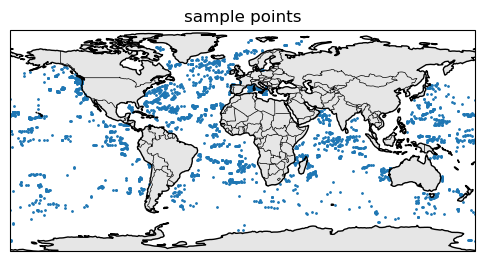

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(
    figsize=(6, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# coarse coastlines
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.scatter(dataset.lon, dataset.lat, s=1, transform=ccrs.PlateCarree())
ax.set_title("sample points")
plt.show()

## Create the train-test dataset

We will use `sklearn`'s split function. Split the dataset into rows for 80% training and 20% rows for testing. Set seed for reproducibility.

In [5]:
from sklearn.model_selection import train_test_split

# rs columns: pace_Rrs_* ending in a digit
y_col = "CHLA_0_10"
rrs_cols = [
    c for c in dataset.columns
    if c.startswith("pace_Rrs_") and c[-1].isdigit()
]
extra = ["solar_hour", "type"]
train_data = dataset[["time", "lat", "lon", y_col] + rrs_cols + extra]
train_data = train_data.rename(columns={y_col: "y"})
# IMPORTANT! log our response so it is symmetric (Normal-ish)
train_data = train_data.where(train_data["y"] > 0)
train_data["y"] = np.log10(train_data["y"])
train_data = train_data.dropna(subset=["y"]) # drop nan

y = train_data["y"]  # target
X = train_data[rrs_cols + extra]  # predictors

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

## Fit a BRT

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

brt_model = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.05, max_iter=400,
    validation_fraction=0.1, early_stopping=True, random_state=42
).fit(X_train, y_train)

### Make a prediction from the model

In [178]:
y_pred = brt_model.predict(X_train)
residuals = y_train - y_pred
df_map = train_data.loc[y_train.index, ["lat", "lon", "time"]]
df_map["y"] = y_train
df_map["y_pred"] = y_pred
df_map["residual"] = residuals

In [179]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def residual_plot(df_map):
    fig, ax = plt.subplots(
        figsize=(7,5),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # symmetric limits around 0
    res = df_map["residual"].values
    max_abs = np.nanmax(np.abs(res))
    vmin, vmax = -max_abs, max_abs

    ax.coastlines(resolution="110m")
    ax.add_feature(cfeature.LAND, facecolor="0.9")

    sc = ax.scatter(
        df_map["lon"],
        df_map["lat"],
        c=df_map["residual"],
        cmap="coolwarm",
        s=6,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(sc, ax=ax, label="Residual (y - y_pred)")
    bias = df_map["residual"].mean()
    plt.title(f"Residual Map (mean bias = {bias:.3f})")
    plt.show()


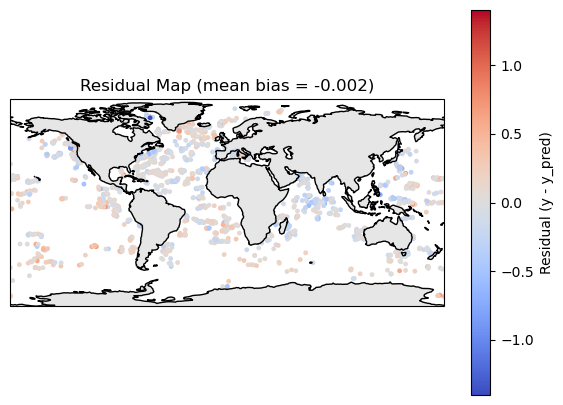

In [180]:
residual_plot(df_map)

## Compare to the test data

In [9]:
y_pred = brt_model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("bias:", np.mean(y_test - y_pred))

R²: 0.8214672986855363
RMSE: 0.3025681970305769
bias: -0.01621315011855349


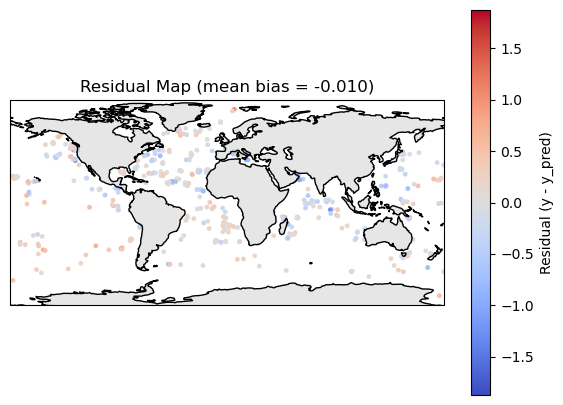

In [182]:
y_pred = brt_model.predict(X_test)
residuals = y_test - y_pred
df_map = train_data.loc[y_test.index, ["lat", "lon", "time"]]
df_map["y"] = y_test
df_map["y_pred"] = y_pred
df_map["residual"] = residuals
residual_plot(df_map)

### Scatter plot of pred versus true

Use the test data.

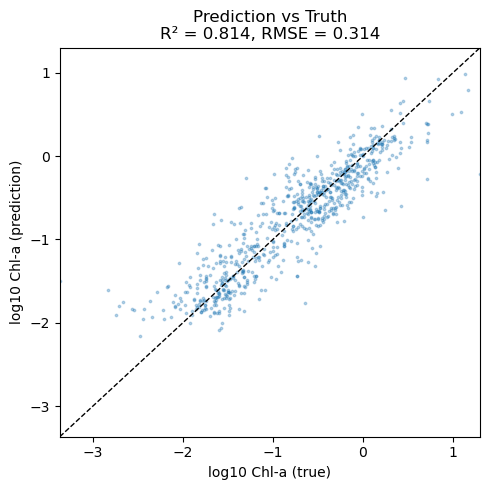

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

y_true = y_test

# Compute some metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("log10 Chl-a (true)")
plt.ylabel("log10 Chl-a (prediction)")
plt.title(f"Prediction vs Truth\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.tight_layout()
plt.show()

## Make a prediction of the whole region

To make a prediction, we use the `predict` attribute for the brt model object. It needs the predictor variables in rows rather than like a lat/lon map and we need to deal with all the NaNs in Rrs data. I create 2 functions:
* `make_prediction()` takes a xarray DataArray of Rrs. So like `ds["Rrs"]`.
* `make_plot()` takes a xarray DataArray of predictions from `make_prediction()` and optionally a data array of chla to compare to our predictions. So like `ds["chlora"]`.


In [7]:
import xarray as xr
def make_prediction(R: xr.Dataset, brt_model, feature_cols, solar_const=0, type_const=1):
    # --- 3. Stack lat/lon into a single "pixel" dimension ---
    R2 = R.stack(pixel=("lat", "lon"))  # (pixel, wavelength)
    R2 = R2.transpose("pixel", "wavelength")
    # Load this subset into memory
    R2_vals = R2.values  # shape: (n_pixel, n_wavelength)

    # --- 4. Make predictions dataframe
    # Map of constant feature names → values you want to use
    constant_values = {
        "solar_hour": solar_const,
        "type": type_const,
    }    
    # Start with the non-constant feature columns (e.g., your spectral bands)
    non_constant_cols = [c for c in feature_cols if c not in constant_values]    
    # Build the base DataFrame from R2_vals
    df_pred = pd.DataFrame(R2_vals, columns=non_constant_cols)    
    # Add any constant columns that are actually in feature_cols
    for name, value in constant_values.items():
        if name in feature_cols:
            df_pred[name] = value

    # Ensure columns are in the correct order expected by the model
    df_pred = df_pred[feature_cols]

    # --- 5. Handle NaNs: BRTs generally cannot handle NaNs in predictors ---
    # Rrs dataset will have loads of NaNs
    valid_mask = ~df_pred.isna().any(axis=1)  # pixels with all bands present
    df_valid = df_pred[valid_mask]

    # Prepare an array for predictions (fill NaNs where we cannot predict)
    y_pred_flat = np.full(df_pred.shape[0], np.nan, dtype=float)

    # --- 6. Predict on the valid pixels ---
    if len(df_valid) > 0:
        y_pred_flat[valid_mask.values] = brt_model.predict(df_valid)

    # --- 7. Reshape back to (lat, lon) ---
    nlat = R.sizes["lat"]
    nlon = R.sizes["lon"]
    pred_map = y_pred_flat.reshape(nlat, nlon)

    pred_da = xr.DataArray(
        pred_map,
        coords={"lat": R["lat"], "lon": R["lon"]},
        dims=("lat", "lon"),
        name="y_pred"
    )

    return pred_da

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def make_plot(
    pred_da: xr.DataArray,
    true_da: xr.DataArray | None = None,
    diff: bool = True,
    shared_colorbar: bool = True,
    true_label: str = "PACE Chlorophyll",
    pred_label: str = "BRT prediction",
    cmap_pred: str = "viridis",
    save = False,
    plot_name = None,
):
    """
    Plot prediction, optionally with truth and difference.

    Parameters
    ----------
    pred_da : xr.DataArray
        Prediction on a lat/lon grid.
    true_da : xr.DataArray or None
        Truth on the same lat/lon grid. If None, only pred is plotted.
 #   diff : bool, default True
        If True and true_da is provided, add a third panel with pred - truth.
    shared_colorbar : bool, default True
        If True, use one colorbar for truth+prediction panels.
    """
    # -----------------------
    # Case 1: only prediction
    # -----------------------
    if true_da is None:
        # robust-ish limits from prediction only
        vals = pred_da.values.ravel()
        vmin, vmax = np.nanpercentile(vals, (0, 100))

        fig, ax = plt.subplots(
            1, 1,
            figsize=(6, 4),
            subplot_kw={"projection": ccrs.PlateCarree()},
            constrained_layout=True,
        )

        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor="0.9")

        im = ax.pcolormesh(
            pred_da["lon"],
            pred_da["lat"],
            pred_da,
            transform=ccrs.PlateCarree(),
           vmin=vmin, vmax=vmax,
            cmap=cmap_pred,
        )

        ax.set_title(pred_label)
        cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.06, pad=0.08)
        cbar.set_label(pred_label)
        plt.show()
        return

    # ------------------------------------------------
    # Case 2: truth + prediction (+/- difference)
    # ------------------------------------------------
    if diff:
        ncols = 3
    else:
        ncols = 2

    fig, axs = plt.subplots(
        1, ncols,
        figsize=(5 * ncols, 5),
        subplot_kw={"projection": ccrs.PlateCarree()},
        constrained_layout=True,
    )

    if ncols == 1:
        axs = [axs]  # just in case, but here ncols>=2

    # 1. Compute robust-ish limits for truth & prediction
    all_vals = np.concatenate([
        true_da.values.ravel(),
        pred_da.values.ravel()
    ])
    vmin, vmax = np.nanpercentile(all_vals, (0, 100))

    # -------------------
    # Panel 1: Truth
    # -------------------
    ax = axs[0]
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="0.9")
    im_truth = ax.pcolormesh(
        true_da["lon"],
        true_da["lat"],
        true_da,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap_pred,
    )
    ax.set_title(true_label)

    # -------------------
    # Panel 2: Prediction
    # -------------------
    ax = axs[1]
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="0.9")
    im_pred = ax.pcolormesh(
        pred_da["lon"],
        pred_da["lat"],
        pred_da,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap_pred,
    )
    ax.set_title(pred_label)

    # -------------------
    # Panel 3: Difference (optional)
    # -------------------
    if diff:
        diff_da = true_da - pred_da

        # Symmetric limits for diff
        diff_vals = diff_da.values.ravel()
        diff_max = np.nanpercentile(np.abs(diff_vals), 98)
        diff_vmin, diff_vmax = -diff_max, diff_max

        ax = axs[2]
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor="0.9")
        im_diff = ax.pcolormesh(
            diff_da["lon"],
            diff_da["lat"],
            diff_da,
            transform=ccrs.PlateCarree(),
            vmin=diff_vmin,
            vmax=diff_vmax,
            cmap="coolwarm",
        )
        ax.set_title("PACE - BRT")

    # -------------------
    # Colorbars
    # -------------------
    if shared_colorbar:
        # one shared colorbar for truth + prediction
        cbar1 = fig.colorbar(
            im_pred,
            ax=axs[:2],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar1.set_label("Value")
    else:
        # separate colorbars for PACE and BRT
        cbar_t = fig.colorbar(
            im_truth,
            ax=axs[0],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar_t.set_label(true_label)

        cbar_p = fig.colorbar(
            im_pred,
            ax=axs[1],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar_p.set_label(pred_label)

    if diff:
        cbar2 = fig.colorbar(
            im_diff,
            ax=axs[-1],
            orientation="horizontal",
            fraction=0.05,
            pad=0.08,
        )
        cbar2.set_label("PACE - BRT")

    if save:
        plt.savefig(plot_name, dpi=70, bbox_inches="tight")
        
    plt.show()


## Load PACE Rrs and Chla data

* Authenticate
* Search
* Open dataset

In [9]:
import earthaccess
import xarray as xr

day = "2024-07-08"

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(rrs_results[0:1], pqdm_kwargs={"disable": True})
rrs_ds = xr.open_dataset(f[0])

# Get chla
chl_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(chl_results[0:1], pqdm_kwargs={"disable": True})
chl_ds = xr.open_dataset(f[0])
chl_ds["log10_chla"] = np.log10(chl_ds["chlor_a"])

## Make a prediction for North Atlantic

In [97]:
# Northwest Atlantic
# Set a box
lat_min, lat_max = 20, 60
lon_min, lon_max = -70, -40
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
R = R.transpose("lat", "lon", "wavelength")

# Get CHLA for that box
chla = chl_ds["log10_chla"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
chla = chla.transpose("lat", "lon")

In [98]:
%%time
# Make prediction
feature_cols = list(X_train.columns)
pred_da = make_prediction(R, brt_model, feature_cols, solar_const=0, type_const=1)

CPU times: user 5.5 s, sys: 828 ms, total: 6.33 s
Wall time: 9.67 s


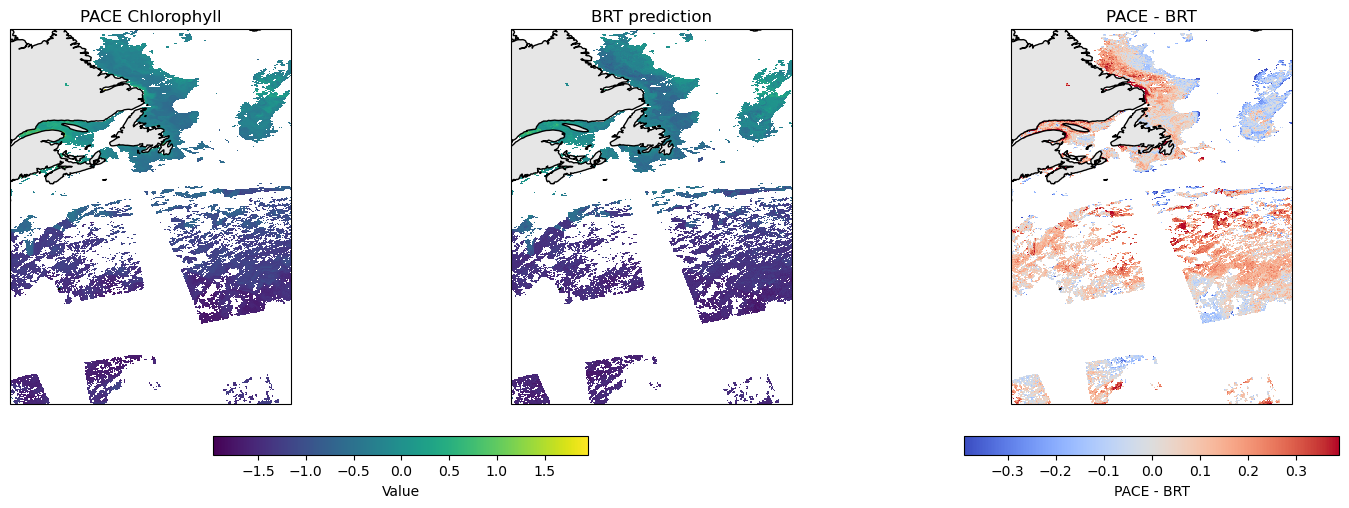

In [99]:
# Make a plot
make_plot(pred_da, chla)

## Scatter plot of PACE chlor_a to BRT with type = 1 (ooi) and solar_hour = 0 (midnight)

We do not expect these to be identical as the PACE chlor_a is based on the classic Rrs ratio algorithm while the BRT uses the whole spectrum but most importantly was trained on Argo and OOI florometer measurements. Here the results are shown for midnight (when bias due to sunlight will not be present) and for OOI, which is less biased relative to PACE chlor_a. Less bias does not mean "better" however, simply that the OOI CHLA_0_10 and PACE chlor_a are more similar in terms of bias.

Notice that at high PACE `chlor_a`, the BRT model predicts lower `CHLA_0_10`. We might be able to correct this by using the whole CHLA depth profile (next section). Rrs is the light emitted from the surface but it measures below the surface depending how far light can descend (euphotic zone).

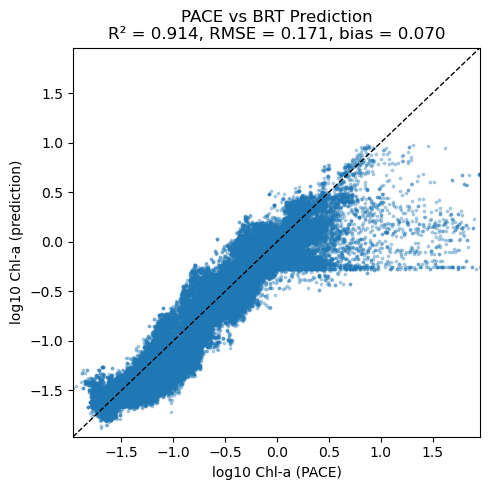

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Flatten and drop NaNs
y_pace = chla.values.ravel()
y_pred = pred_da.values.ravel()

mask = np.isfinite(y_pace) & np.isfinite(y_pred)# & (y_pace < 0)
y_pace = y_pace[mask]
y_pred = y_pred[mask]

# Compute some metrics
r2 = r2_score(y_pace, y_pred)
rmse = np.sqrt(mean_squared_error(y_pace, y_pred))
bias = np.mean(y_pace - y_pred)

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_pace, y_pred, s=3, alpha=0.3)

# 1:1 line
lims = [
    min(y_pace.min(), y_pred.min()),
    max(y_pace.max(), y_pred.max())
]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("log10 Chl-a (PACE)")
plt.ylabel("log10 Chl-a (prediction)")
plt.title(f"PACE vs BRT Prediction\nR² = {r2:.3f}, RMSE = {rmse:.3f}, bias = {bias:.3f}")
plt.tight_layout()
plt.show()


### Make a prediction for the whole globe

Takes 2 min or so. Do in latitude batches to not max out the RAM.

In [10]:
%%time
## How long does a global prediciton take, ABOUT 2 MIN

R = rrs_ds["Rrs"]
R = R.transpose("lat", "lon", "wavelength")
feature_cols = list(X_train.columns)
nlat = R.sizes["lat"]
chunks = []
lat_coord = R["lat"]
chunk_size_lat = 100

for start in range(0, nlat, chunk_size_lat):
    stop = min(start + chunk_size_lat, nlat)
    R_chunk = R.isel(lat=slice(start, stop))

    # your existing BRT helper, but allow consts and any helpers
    pred_chunk = make_prediction(
        R_chunk,
        brt_model=brt_model,
        feature_cols=feature_cols,
        solar_const=0, type_const=1,
    )

    chunks.append(pred_chunk)

# concat along lat
pred_da = xr.concat(chunks, dim="lat")
pred_da = pred_da.assign_coords(lat=lat_coord)


CPU times: user 2min 8s, sys: 27.3 s, total: 2min 36s
Wall time: 2min 22s


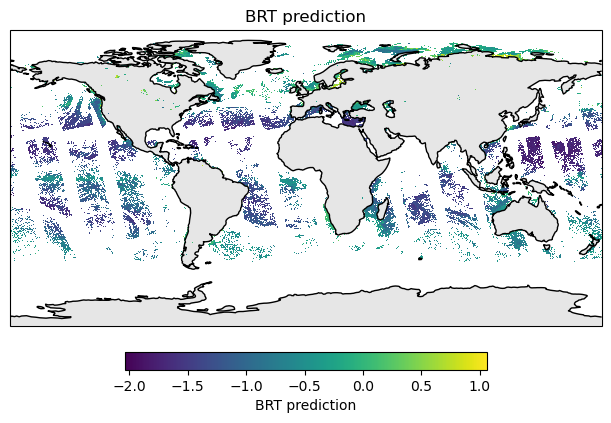

CPU times: user 26.5 s, sys: 5.03 s, total: 31.5 s
Wall time: 31.5 s


In [11]:
%%time
make_plot(pred_da, save=True, plot_name="figures/global_CHLA_0_10_pred.jpg")
#make_plot(pred_da)

## Chlorophyll depth profiles

So far we have fit the BRT to CHLA_0_10 (0 to 10m). Now let's fit to all the 10m depth bins down to 200m. Although no much light penetrates as we go deeper, there may still be information about CHLA in the deeper bins that we can extract using the full Rrs spectrum. 


## Step 1 Get a BRT model for all depth bins

Store the models in a list.

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

# Global indices for rows
all_idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(
    all_idx,
    test_size=0.2,
    random_state=42,
)

# Fit one BRT per depth range

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# CHLA bin columns like CHLA_0_10, CHLA_10_20, ...
chl_cols = [
    c for c in dataset.columns
    if c.startswith("CHLA_") and c[-1].isdigit()
]
# extra predictors
#extra = ["solar_hour", "type", "x_geo", "y_geo", "z_geo"]
extra = ["solar_hour", "type"]

def parse_depth_bin(col):
    _, a, b = col.split("_")
    return int(a), int(b)
    
# Ensure that cols are sorted by min depth
chl_cols = sorted(chl_cols, key=lambda c: parse_depth_bin(c)[0])

# Rrs predictor columns
rrs_cols = [
    c for c in dataset.columns
    if c.startswith("pace_Rrs_") and c[-1].isdigit()
]

def fit_brt_bin_for_train_rows(var, dataset, train_idx, seed=42, extras=["solar_hour"]):
    y_col = var
    df = dataset.iloc[train_idx][["time", "lat", "lon", y_col] + rrs_cols + extras].copy()
    df = df.rename(columns={y_col: "y"})

    # log10 transform of CHLA (positive only)
    df = df.where(df["y"] > 0)
    df["y"] = np.log10(df["y"])
    df = df.dropna(subset=["y"])

    y = df["y"]
    X = df[rrs_cols + extras]

    model = HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=400,
        validation_fraction=0.1,
        early_stopping=True,
        random_state=seed,
    ).fit(X, y)

    # return the model
    return model

# Fit models for all bins
brt_models = {}
depth_centers = []

for c in chl_cols:
    a, b = parse_depth_bin(c)
    depth_centers.append((a + b) / 2)
    brt_models[c] = fit_brt_bin_for_train_rows(c, dataset, train_idx, extras=extra)


### Save model

In [21]:
bundle_meta = {
    "target_name": "log10_CHLA_A_B depth bins",
    "feature_cols": rrs_cols + extra,
    "y_col": chl_cols,
    "rrs_cols": rrs_cols,
    "extra_cols": extra,
    "description": "BRT models for each CHLA depth bin.",
    "author": "Elizabeth Eli Holmes (NOAA)",
    "date": "2025-12-09",
    "data_source": (
        "CHLA_ooi_profiles_plus_PACE.parquet and "
        "CHLA_argo_profiles_plus_PACE.parquet combined with biofouled rows removed"
    ),
}

mu.save_ml_bundle(
    "models/brt_chla_profiles_bundle.zip",
    model=brt_models,          # dict of models
    dataset=dataset,
    train_idx=train_idx,
    test_idx=test_idx,
    meta=bundle_meta,
    predict_helper=mu.predict_all_depths_for_day, 
    plot_helper=mu.make_plot_pred_map,
    extra_helpers={
        "make_prediction_brt": mu.make_prediction_brt,
        "add_spherical_coords": mu.add_spherical_coords,
        "add_seasonal_time_features": mu.add_seasonal_time_features,
        "add_solar_hour_feature": mu.add_solar_time_feature,
    },
)

'models/brt_chla_profiles_bundle.zip'

In [12]:
## Later to load model use
bundle = mu.load_ml_bundle("models/brt_chla_profiles_bundle.zip")
brt_models = bundle.model
meta = bundle.meta
rrs_cols = meta["rrs_cols"]
chl_cols = meta["y_col"]
extra = meta["extra_cols"]
dataset = bundle.data["dataset"]
train_idx = bundle.data["train_idx"]
test_idx = bundle.data["test_idx"]
X_train = bundle.data["X_train"]
X_test = bundle.data["X_test"]
y_train_all = bundle.data["y_train"]
y_test_all = bundle.data["y_test"]



Loaded ML bundle from: models/brt_chla_profiles_bundle.zip
  model_kind : pickle
  model_type : collection (dict), n_submodels=20
  example key: CHLA_0_10
  target     : log10_CHLA_A_B depth bins
  features   : 174 columns
  train/test : 4408 / 1102 rows
  dataset    : 5510 rows stored in bundle

Usage example (Python):
  bundle = load_ml_bundle('path/to/bundle.zip')
  # Predict using helper 'predict_all_depths_for_day'
  # Example: predict all depths for one day from a BRF dataset R
  pred = bundle.predict(
      R_dataset,                  # xr.DataArray/xr.Dataset with lat/lon + predictors
      brt_models=bundle.model,    # dict of models by depth bin
      feature_cols=bundle.meta['feature_cols'],
      consts={'solar_hour': 12.0, 'type': 1},
  )  # -> e.g. CHLA(time?, z, lat, lon)

  # Plot using helper 'make_plot_pred_map'
  fig, ax = bundle.plot(pred_da, pred_label='Prediction')



/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Get model fit metrics for a depth bin (var)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def model_fit_metrics(
    var,
    dataset,
    brt_model,
    idx,
    extras=("solar_hour", "type"),
):
    """
    Compute metrics for a *fitted* BRT for one CHLA_A_B bin column `var`
    using a specified subset of rows (idx).

    Parameters
    ----------
    var : str
        CHLA column name like "CHLA_10_20".
    dataset : pd.DataFrame
        Full dataset used for training/validation.
    brt_model :
        Fitted HistGradientBoostingRegressor (or compatible .predict() model).
    idx : array-like of int
        Row indices to use for evaluation (e.g. train_idx, test_idx, valid_idx).
    extras : sequence of str, optional
        Names of extra predictor columns beyond the Rrs ones.

    Returns
    -------
    metrics : dict
        {
          "N": int,
          "r2_log": float,
          "rmse_log": float,
          "bias_log": float,
          "rmse_lin": float,
          "bias_lin": float,
          "rmse_rel": float,
          "bias_rel": float,
          "p90_abs_err": float,
          "median_abs_err": float,
        }
    y_pred_lin : np.ndarray
        Predicted CHLA (linear scale) for the used rows.
    y_true_lin : np.ndarray
        True CHLA (linear scale) for the used rows.
    """
    y_col = var

    # Rrs predictor columns
    rrs_cols = [
        c for c in dataset.columns
        if c.startswith("pace_Rrs_") and c[-1].isdigit()
    ]

    extras = list(extras)

    # Subset the dataset to the index set and relevant columns
    df = dataset.loc[idx, ["time", "lat", "lon", y_col] + rrs_cols + extras].copy()
    df = df.rename(columns={y_col: "y"})

    # Keep only positive, finite CHLA
    mask_valid = np.isfinite(df["y"]) & (df["y"] > 0)
    df = df[mask_valid]

    if df.empty:
        metrics = {
            "N": 0,
            "r2_log": np.nan,
            "rmse_log": np.nan,
            "bias_log": np.nan,
            "rmse_lin": np.nan,
            "bias_lin": np.nan,
            "rmse_rel": np.nan,
            "bias_rel": np.nan,
            "p90_abs_err": np.nan,
            "median_abs_err": np.nan,
        }
        return metrics, np.array([]), np.array([])

    # Log10 transform for the model space
    y_log = np.log10(df["y"].values.astype(float))
    X = df[rrs_cols + extras]

    # ---- log10-scale metrics ----
    y_pred_log = brt_model.predict(X)
    y_true_log = y_log

    r2_log = r2_score(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    bias_log = np.mean(y_true_log - y_pred_log)

    # Number of samples
    N = len(y_true_log)

    # ---- back-transform for linear-scale metrics ----
    y_true_lin = 10.0**y_true_log
    y_pred_lin = 10.0**y_pred_log

    diff = y_true_lin - y_pred_lin
    rmse_lin = np.sqrt(mean_squared_error(y_true_lin, y_pred_lin))
    bias_lin = np.mean(diff)

    mean_true = np.mean(y_true_lin)
    if mean_true > 0:
        rmse_rel = rmse_lin / mean_true
        bias_rel = bias_lin / mean_true
    else:
        rmse_rel = np.nan
        bias_rel = np.nan

    abs_diff = np.abs(diff)
    p90_abs_err = np.percentile(abs_diff, 90)
    median_abs_err = np.median(abs_diff)

    metrics = {
        "N": N,
        "r2_log": r2_log,
        "rmse_log": rmse_log,
        "bias_log": bias_log,
        "rmse_lin": rmse_lin,
        "bias_lin": bias_lin,
        "rmse_rel": rmse_rel,
        "bias_rel": bias_rel,
        "p90_abs_err": p90_abs_err,
        "median_abs_err": median_abs_err,
    }

    return metrics, y_pred_lin, y_true_lin


In [6]:
# test
extra = ["solar_hour", "type"]
var = "CHLA_100_110"
m, pred, true = model_fit_metrics(var, dataset, brt_models[var], test_idx, extras=extra)
m

{'N': 485,
 'r2_log': 0.3668705916482011,
 'rmse_log': np.float64(0.3256114233126042),
 'bias_log': np.float64(-0.023617653310894052),
 'rmse_lin': np.float64(0.3037233351798303),
 'bias_lin': np.float64(0.03349229734937781),
 'rmse_rel': np.float64(2.054375077122543),
 'bias_rel': np.float64(0.22654084484289053),
 'p90_abs_err': np.float64(0.14097699171579478),
 'median_abs_err': np.float64(0.03671051912541501)}

### Get metrics table for all bins

In [14]:
import numpy as np
import pandas as pd

def parse_depth_bin(col):
    """
    Expect names like CHLA_0_10, CHLA_10_20, etc.
    Returns (z_start, z_end) as ints.
    """
    _, a, b = col.split("_")
    return int(a), int(b)

def depth_metrics_table(
    brt_models,
    dataset,
    idx,
    extras=("solar_hour", "type"),
):
    """
    Compute model_fit_metrics for all CHLA depth bins and return as a DataFrame.

    Parameters
    ----------
    brt_models : dict
        Mapping from CHLA bin name -> fitted model, e.g. {"CHLA_0_10": model, ...}
    dataset : pd.DataFrame
        Full dataset used for training/validation.
    idx : array-like of int
        Row indices for evaluation (e.g. train_idx, test_idx, valid_idx, etc.).
    extras : sequence of str, optional
        Extra predictor column names (beyond pace_Rrs_*).

    Returns
    -------
    metrics_df : pd.DataFrame
        One row per depth bin with columns:
          ["var", "z_start", "z_end", "z_center", ...all metrics from model_fit_metrics...]
    """
    extras = list(extras)

    # Depth bins from the model keys
    chl_cols = list(brt_models.keys())
    chl_cols = sorted(chl_cols, key=lambda c: parse_depth_bin(c)[0])

    rows = []

    for var in chl_cols:
        z_start, z_end = parse_depth_bin(var)
        z_center = 0.5 * (z_start + z_end)

        model = brt_models[var]

        # metrics, y_pred_lin, y_true_lin come from the helper we defined earlier
        metrics, y_pred_lin, y_true_lin = model_fit_metrics(
            var=var,
            dataset=dataset,
            brt_model=model,
            idx=idx,
            extras=extras,
        )

        row = {
            "var": var,
            "z_start": z_start,
            "z_end": z_end,
            "z_center": z_center,
        }
        row.update(metrics)   # add all metric keys/values

        rows.append(row)

    metrics_df = pd.DataFrame(rows)
    metrics_df = metrics_df.sort_values("z_center").reset_index(drop=True)
    return metrics_df


In [15]:
metrics_df = depth_metrics_table(
    brt_models,
    dataset,
    test_idx,
    extras=("solar_hour", "type"),
)
metrics_df.head()
depth_centers = metrics_df["z_center"].values

## Make plots of performance

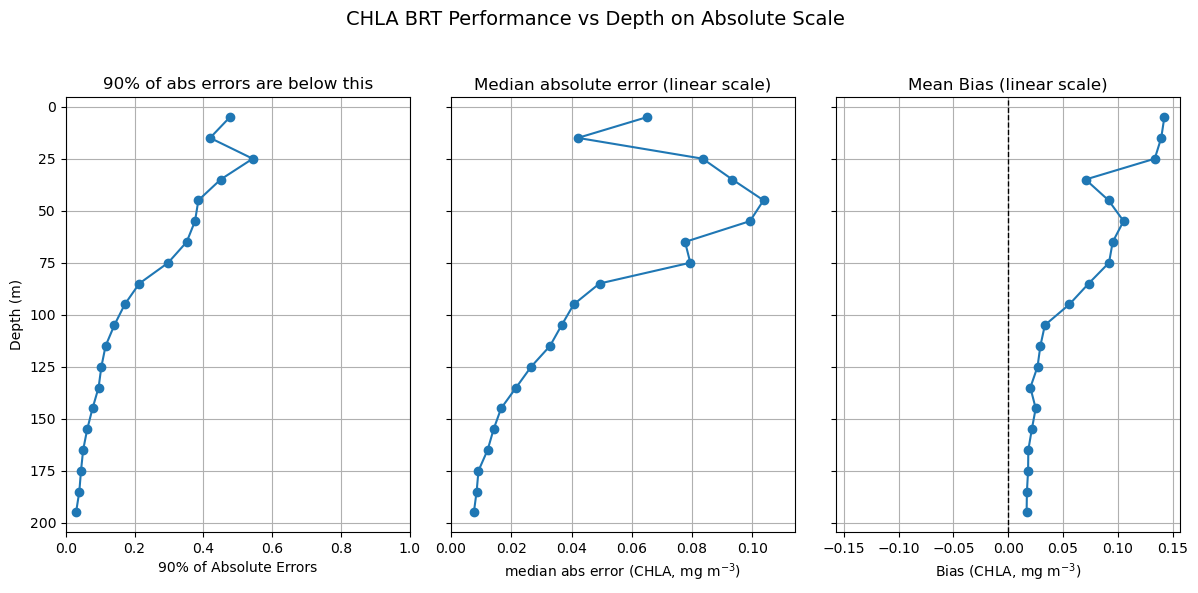

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
ax_r2, ax_rmse, ax_bias = axes

# ---- Panel 1: R² (log-scale fit) ----
ax_r2.plot(metrics_df["p90_abs_err"], depth_centers, marker="o")
ax_r2.set_xlabel("90% of Absolute Errors")
ax_r2.set_ylabel("Depth (m)")
ax_r2.set_xlim(0, 1.0)
ax_r2.invert_yaxis()
ax_r2.grid(True)
ax_r2.set_title("90% of abs errors are below this")

# ---- Panel 2: RMSE on log scale ----
rmse_lin_vals = metrics_df["median_abs_err"]
max_rmse = np.nanmax(rmse_lin_vals)
ax_rmse.plot(rmse_lin_vals, depth_centers, marker="o")
ax_rmse.set_xlabel("median abs error (CHLA, mg m$^{-3}$)")
ax_rmse.set_xlim(0, max_rmse * 1.1 if np.isfinite(max_rmse) else 1.0)
ax_rmse.grid(True)
ax_rmse.set_title("Median absolute error (linear scale)")

# ---- Panel 3: Bias on log scale ----
bias_lin_vals = metrics_df["bias_lin"]
max_abs_bias = np.nanmax(np.abs(bias_lin_vals))
lim_bias = max_abs_bias * 1.1 if np.isfinite(max_abs_bias) else 0.1

ax_bias.axvline(0.0, color="k", linestyle="--", linewidth=1)
ax_bias.plot(bias_lin_vals, depth_centers, marker="o")
ax_bias.set_xlabel("Bias (CHLA, mg m$^{-3}$)")
ax_bias.set_xlim(-lim_bias, lim_bias)
ax_bias.grid(True)
ax_bias.set_title("Mean Bias (linear scale)")

fig.suptitle("CHLA BRT Performance vs Depth on Absolute Scale", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

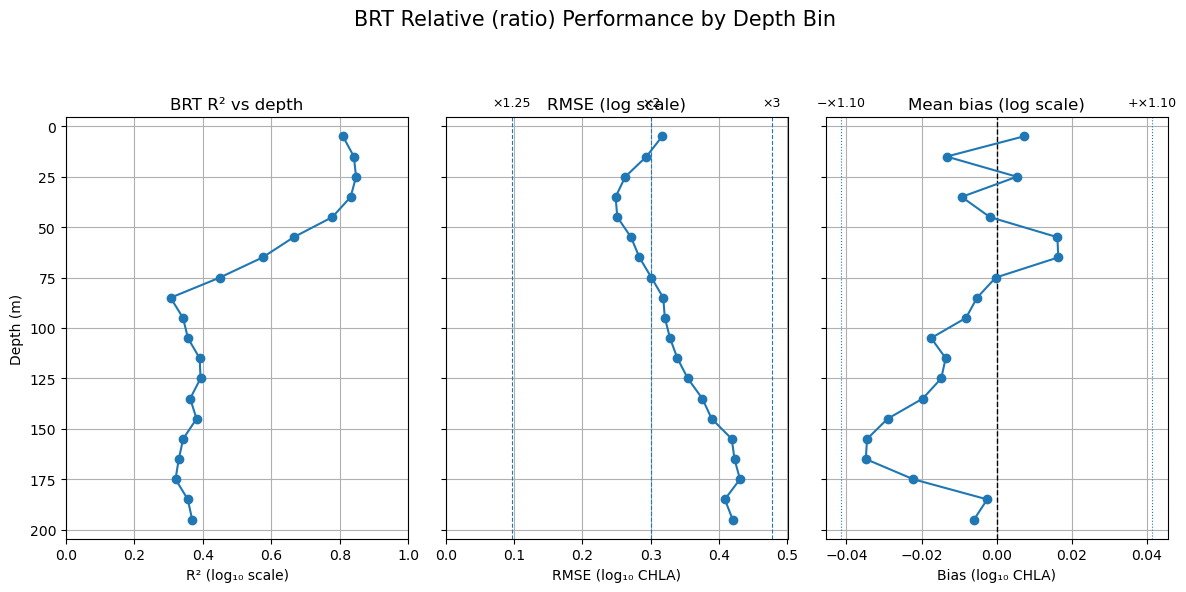

In [156]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
ax_r2, ax_rmse, ax_bias = axes

# Use depth centers from the metrics table
depth_centers = metrics_df["z_center"].values

# ---- Panel 1: R² (log10-scale fit) ----
r2_log_vals = metrics_df["r2_log"].values
ax_r2.plot(r2_log_vals, depth_centers, marker="o")
ax_r2.set_xlabel("R² (log₁₀ scale)")
ax_r2.set_ylabel("Depth (m)")
ax_r2.set_xlim(0, 1.0)
ax_r2.invert_yaxis()
ax_r2.grid(True)
ax_r2.set_title("BRT R² vs depth")

# -------------------------
# Helper: multiplicative scales
# -------------------------
ratio_lines_rmse = [1.25, 2.0, 3.0]
ratio_labels_rmse = ["×1.25", "×2", "×3"]
log_ratios_rmse = np.log10(ratio_lines_rmse)

# ---- Panel 2: RMSE on log scale ----
rmse_log_vals = metrics_df["rmse_log"].values
max_rmse = np.nanmax(rmse_log_vals)

# Make sure axis covers at least up to log10(3)
target_rmse_max = max_rmse
if np.isfinite(target_rmse_max):
    target_rmse_max = max(target_rmse_max, log_ratios_rmse[-1] * 1.05)
else:
    target_rmse_max = log_ratios_rmse[-1] * 1.05

ax_rmse.plot(rmse_log_vals, depth_centers, marker="o")
ax_rmse.set_xlabel("RMSE (log₁₀ CHLA)")
ax_rmse.set_xlim(0, target_rmse_max)
ax_rmse.grid(True)
ax_rmse.set_title("RMSE (log scale)")

# Add vertical guide lines for multiplicative error factors (labels above axis)
for x, lab in zip(log_ratios_rmse, ratio_labels_rmse):
    ax_rmse.axvline(x, linestyle="--", linewidth=0.8)
    ax_rmse.annotate(
        lab,
        xy=(x, 1.02),                   # x in data coords, y just above top of axes
        xycoords=("data", "axes fraction"),
        ha="center",
        va="bottom",
        fontsize=9,
    )

# ---- Panel 3: Bias on log scale ----
bias_log_vals = metrics_df["bias_log"].values
max_abs_bias = np.nanmax(np.abs(bias_log_vals))

# Only need ±1.10  for bias
ratio_lines_bias = [1.10]
ratio_labels_bias = ["×1.10"]
log_ratios_bias = np.log10(ratio_lines_bias)

# Ensure bias limits cover at least ±log10(1.15)
target_bias_lim = max_abs_bias
min_needed = max(log_ratios_bias)  # log10(1.25)
if np.isfinite(target_bias_lim):
    target_bias_lim = max(target_bias_lim, min_needed) * 1.1
else:
    target_bias_lim = min_needed * 1.1

ax_bias.axvline(0.0, color="k", linestyle="--", linewidth=1)
ax_bias.plot(bias_log_vals, depth_centers, marker="o")
ax_bias.set_xlabel("Bias (log₁₀ CHLA)")
ax_bias.set_xlim(-target_bias_lim, target_bias_lim)
ax_bias.grid(True)
ax_bias.set_title("Mean bias (log scale)")

# Add symmetric guide lines for bias (+/- multiplicative factors)
for x, lab in zip(log_ratios_bias, ratio_labels_bias):
    # positive bias: truth ≈ lab * prediction
    ax_bias.axvline(x, linestyle=":", linewidth=0.8)
    ax_bias.annotate(
        f"+{lab}",
        xy=(x, 1.02),
        xycoords=("data", "axes fraction"),
        ha="center",
        va="bottom",
        fontsize=9,
    )
    # negative bias: truth ≈ prediction / lab
    ax_bias.axvline(-x, linestyle=":", linewidth=0.8)
    ax_bias.annotate(
        f"−{lab}",
        xy=(-x, 1.02),
        xycoords=("data", "axes fraction"),
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Global title
fig.suptitle("BRT Relative (ratio) Performance by Depth Bin", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()



### Get a predicted profile given a row from X (_train or _test)

In [17]:
import matplotlib.pyplot as plt
import numpy as np

rrs_cols = [c for c in dataset.columns if c.startswith("pace_Rrs_") and c[-1].isdigit()]

def predict_profile_for_row(row, brt_models, chl_cols, depth_centers, extras=["solar_hour"]):
    """
    Given a single row (one Argo profile) and the dict of BRT models,
    return predicted CHLA profile (in linear space) across depth bins.
    """
    if not extras == None:
        X_row = row[rrs_cols + extras].to_frame().T  # shape (1, n_features)

    preds_log10 = []
    for c in chl_cols:
        model = brt_models[c]
        y_log10 = model.predict(X_row)[0]
        preds_log10.append(y_log10)

    preds_log10 = np.array(preds_log10)
    preds = 10 ** preds_log10  # back to mg m-3
    return preds


### Pick a test profile (example using profile_id)

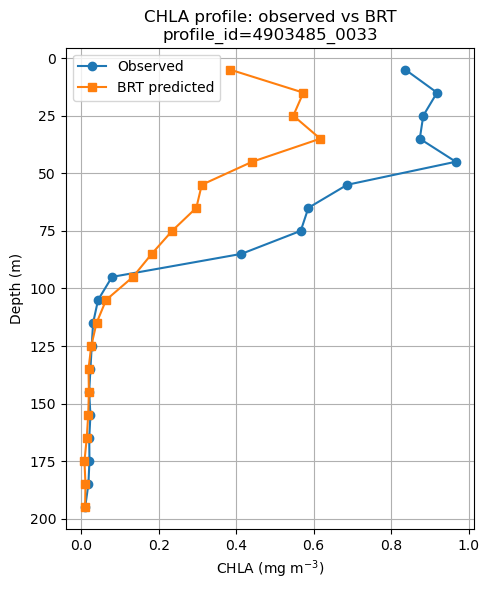

In [18]:
# pick a test profile (example using profile_id)
profile_id_to_plot = dataset["profile_id"].iloc[0]
row = dataset.loc[dataset["profile_id"] == profile_id_to_plot].iloc[0]

extra = ["solar_hour", "x_geo", "y_geo", "z_geo"]
extra = ["solar_hour", "type"]
pred_profile = predict_profile_for_row(row, brt_models, chl_cols, depth_centers, extras=extra)

# observed profile from that row (line up with chl_cols order)
obs_profile = row[chl_cols].to_numpy()

# plot comparison
plt.figure(figsize=(5, 6))
plt.plot(obs_profile, depth_centers, marker="o", label="Observed")
plt.plot(pred_profile, depth_centers, marker="s", label="BRT predicted")

plt.gca().invert_yaxis()
plt.xlabel("CHLA (mg m$^{-3}$)")
plt.ylabel("Depth (m)")
plt.title(f"CHLA profile: observed vs BRT\nprofile_id={profile_id_to_plot}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Use the brt_models list to make multiple predictions

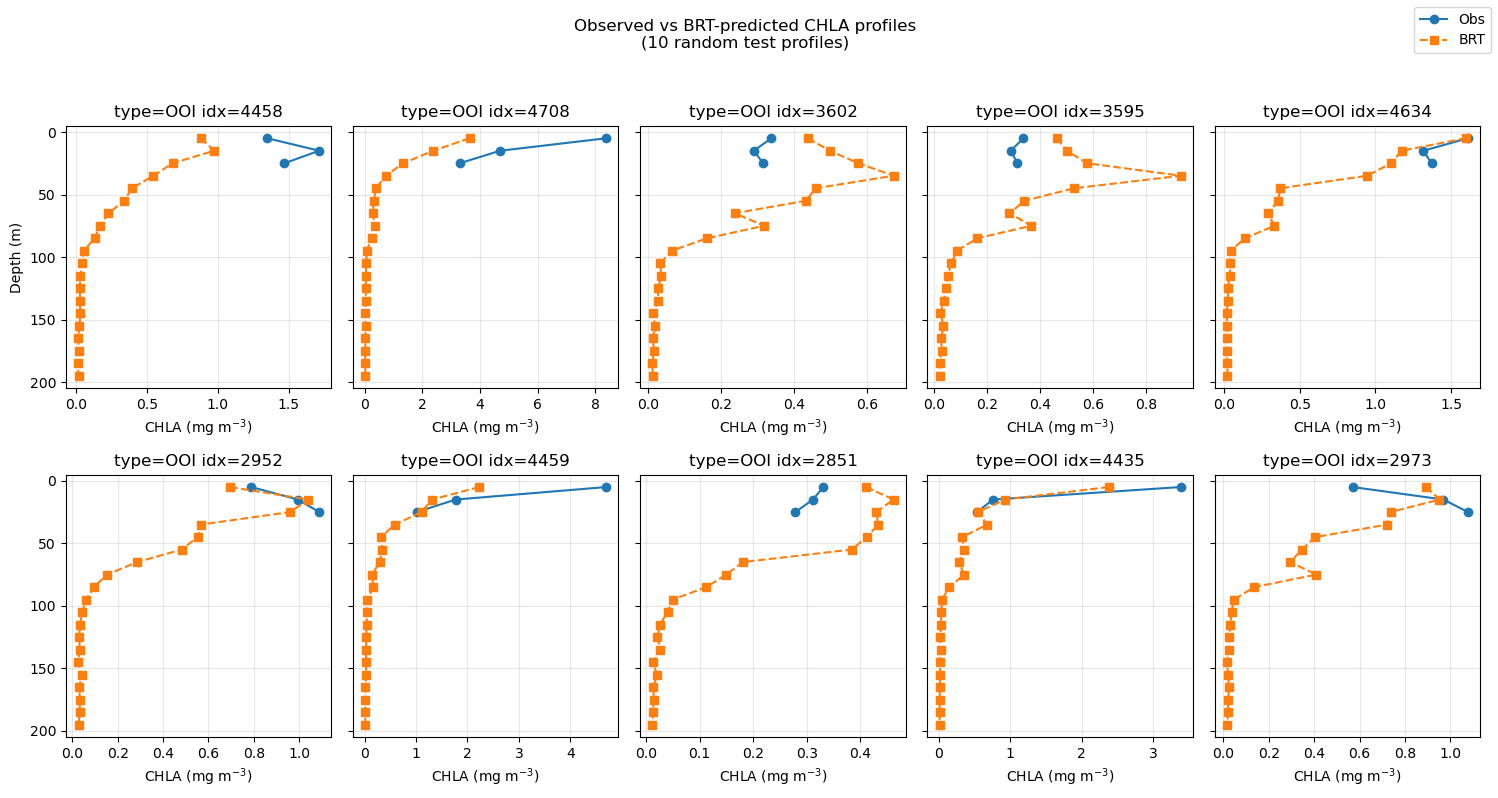

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Sample 10 random indices from test set
n_profiles = 10
# 1. Filter test_idx to those with >= 3 non-NaN CHLA bins
inshore = ["ooi-ce01issp-sp001-08-flortj000", "ooi-ce06issp-sp001-08-flortj000", 
           "ooi-cp03ispm-wfp01-04-flortk000", "ooi-cp03issm-rid27-02-flortd000",
          "ooi-cp03issp-sp001-09-flortj000" ]
valid_idx = [
    i for i in train_idx
#    if dataset.loc[i, chl_cols].count() >= 10
#    if dataset.loc[i, chl_cols].count() >= 5 and dataset.loc[i, chl_cols].max() >= 1
#    if dataset.loc[i, chl_cols].count() >= 10 and dataset.loc[i, "CHLA_0_10"].max() >= 1
    if dataset.loc[i, chl_cols].count() >= 3 and dataset.loc[i, "profile_id"].split("_")[0] in inshore 
#    if dataset.loc[i, "CHLA_100_110"] >= 1
]
# 2. Sample from valid_idx with a seed
rng = np.random.default_rng()
n_to_plot = min(n_profiles, len(valid_idx))  # just in case there are fewer than 10
sample_idx = rng.choice(valid_idx, size=n_to_plot, replace=False)

ncols = 5
nrows = int(np.ceil(n_profiles / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 4 * nrows), sharey=True)
axes = np.atleast_1d(axes).ravel()

for ax, idx in zip(axes, sample_idx):
    row = dataset.iloc[idx]

    # observed profile (line up with chl_cols order)
    obs_profile = row[chl_cols].to_numpy()

    # predicted profile
    pred_profile = predict_profile_for_row(row, brt_models, chl_cols, depth_centers, extras=extra)

    ax.plot(obs_profile, depth_centers, marker="o", label="Obs", linestyle="-")
    ax.plot(pred_profile, depth_centers, marker="s", label="BRT", linestyle="--")

    ax.set_xlabel("CHLA (mg m$^{-3}$)")
    ax.grid(True, alpha=0.3)

    prof_id = row.get("type", idx)
    if prof_id == 0:
        prof_id = "Argo"
    else:
        prof_id = "OOI"
    ax.set_title(f"type={prof_id} idx={idx}")

# turn off any unused axes
for ax in axes[n_profiles:]:
    ax.axis("off")

# Depth axis settings: 0–200 with a little padding
min_depth = 0
max_depth = 200
pad = 5  # meters

for ax in axes:
    # limits WITH padding, then invert so 0 is at top
    ax.set_ylim(min_depth - pad, max_depth + pad)
    ax.invert_yaxis()
    ax.set_yticks([0, 50, 100, 150, 200])

axes[0].set_ylabel("Depth (m)")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle("Observed vs BRT-predicted CHLA profiles\n(10 random test profiles)", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig("figures/pred_vs_obs_profiles.jpg", dpi=70, bbox_inches="tight")
plt.show()


In [36]:
valid_idx = [
    i for i in train_idx
#    if dataset.loc[i, chl_cols].count() >= 10
#    if dataset.loc[i, chl_cols].count() >= 5 and dataset.loc[i, chl_cols].max() >= 1
#    if dataset.loc[i, chl_cols].count() >= 10 and dataset.loc[i, "CHLA_0_10"].max() >= 1
    if dataset.loc[i, chl_cols].count() >= 3 and dataset.loc[i, "profile_id"].split("_")[0] in inshore 
#    if dataset.loc[i, "CHLA_100_110"] >= 1
]
valid_idx

[np.int64(2851),
 np.int64(4588),
 np.int64(2858),
 np.int64(5097),
 np.int64(4708),
 np.int64(4459),
 np.int64(2973),
 np.int64(3560),
 np.int64(5019),
 np.int64(2952),
 np.int64(4435),
 np.int64(2906),
 np.int64(4458),
 np.int64(4634),
 np.int64(3595),
 np.int64(4441),
 np.int64(4538),
 np.int64(2994),
 np.int64(4720),
 np.int64(3584),
 np.int64(3602),
 np.int64(3498)]

In [27]:
dataset.loc[:, "profile_id"]

0                                   4903485_0033
1                                   6904240_0068
2                                   1902495_0002
3                                   2903863_0040
4                                   2902882_0079
                          ...                   
5505    ooi-cp11nosm-rid27-02-flortd000_20251126
5506    ooi-cp11sosm-rid27-02-flortd000_20251126
5507    ooi-cp11sosm-rid27-02-flortd000_20251128
5508    ooi-cp11nosm-rid27-02-flortd000_20251201
5509    ooi-ce04osps-sf01b-3a-flortd104_20251202
Name: profile_id, Length: 5510, dtype: object

## Get where the peak is, how big and how much in the water column

In [149]:
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d

def predict_profile_for_row(row, brt_models, chl_cols, depth_centers, extras=["solar_hour"]):
    """
    Given one row (Series) and fitted BRTs, return predicted CHLA profile
    (linear units) across bins, in the same order as `chl_cols`.
    """
    X_row = row[rrs_cols + extras].to_frame().T

    preds_log10 = []
    for c in chl_cols:
        model = brt_models[c]
        y_log10 = model.predict(X_row)[0]
        preds_log10.append(y_log10)

    preds_log10 = np.array(preds_log10, dtype=float)
    preds = 10 ** preds_log10  # back to mg m-3
    return preds


def peak_depth_for_row(
    row,
    brt_models,
    chl_cols,
    depth_centers,
    extras=["solar_hour"],
    smooth=True,
    smooth_window=3,
    dz=10.0,
):
    """
    For a single profile (row), compute:
      - observed & predicted peak CHLA depth (m)
      - observed & predicted peak CHLA value (mg m-3)
      - observed & predicted integrated CHLA 0–200 m (mg m-2)

    Returns a Series with:
      peak_obs_m, peak_pred_m, peak_error_m,
      peak_obs_val, peak_pred_val, peak_error_val,
      int_obs_0_200, int_pred_0_200, int_error_0_200
    """
    # observed profile
    obs = row[chl_cols].to_numpy(dtype="float")

    # predicted profile
    pred = predict_profile_for_row(row, brt_models, chl_cols, depth_centers, extras)

    # only trust bins where we have observed data
    valid = ~np.isnan(obs)
    if valid.sum() < 10:
        return pd.Series(
            {
                "peak_obs_m":      np.nan,
                "peak_pred_m":     np.nan,
                "peak_error_m":    np.nan,
                "peak_obs_val":    np.nan,
                "peak_pred_val":   np.nan,
                "peak_error_val":  np.nan,
                "int_obs_0_200":   np.nan,
                "int_pred_0_200":  np.nan,
                "int_error_0_200": np.nan,
            }
        )

    obs_valid   = obs[valid]
    pred_valid  = pred[valid]
    depth_valid = depth_centers[valid]

    # optional smoothing to reduce jaggedness for peak detection
    if smooth:
        obs_s  = uniform_filter1d(obs_valid, size=smooth_window, mode="nearest")
        pred_s = uniform_filter1d(pred_valid, size=smooth_window, mode="nearest")
    else:
        obs_s  = obs_valid
        pred_s = pred_valid

    # --- Peak depth & value (use smoothed profiles for peak detection) ---
    i_obs_peak  = int(np.argmax(obs_s))
    i_pred_peak = int(np.argmax(pred_s))

    peak_obs_m   = depth_valid[i_obs_peak]
    peak_pred_m  = depth_valid[i_pred_peak]
    peak_error_m = peak_pred_m - peak_obs_m

    peak_obs_val   = obs_s[i_obs_peak]
    peak_pred_val  = pred_s[i_pred_peak]
    peak_error_val = peak_pred_val - peak_obs_val

    # --- Integrated CHLA 0–200 m (mg m-2) over valid bins ---
    int_obs_0_200  = np.nansum(obs_valid  * dz)
    int_pred_0_200 = np.nansum(pred_valid * dz)
    int_error_0_200 = int_pred_0_200 - int_obs_0_200

    return pd.Series(
        {
            "peak_obs_m":      peak_obs_m,
            "peak_pred_m":     peak_pred_m,
            "peak_error_m":    peak_error_m,
            "peak_obs_val":    peak_obs_val,
            "peak_pred_val":   peak_pred_val,
            "peak_error_val":  peak_error_val,
            "int_obs_0_200":   int_obs_0_200,
            "int_pred_0_200":  int_pred_0_200,
            "int_error_0_200": int_error_0_200,
        }
    )


In [150]:
%%time
# ---- apply to the whole test dataset ----

# depth_centers: 5, 15, ..., 195 (must match chl_cols order)
depth_centers = np.arange(5, 5 + 10*len(chl_cols), 10)
extra = ["solar_hour", "type"]
df = dataset.loc[test_idx]

peak_df = df.apply(
    peak_depth_for_row,
    axis=1,
    args=(brt_models, chl_cols, depth_centers, extra),
)

peak_df[
    [
        "peak_obs_m", "peak_pred_m", "peak_error_m",
        "peak_obs_val", "peak_pred_val", "peak_error_val",
        "int_obs_0_200", "int_pred_0_200", "int_error_0_200",
    ]
].head()


,peak_obs_m,peak_pred_m,peak_error_m,peak_obs_val,peak_pred_val,peak_error_val,int_obs_0_200,int_pred_0_200,int_error_0_200
1433,45.0,65.0,20.0,0.552569,0.269209,-0.283360,60.357637,29.869666,-30.487972
1200,45.0,45.0,0.0,0.422407,0.552620,0.130213,24.065508,38.637324,14.571816
4501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Predicting where the peak is in the water column

We tend to get the location of the peak within 10m.

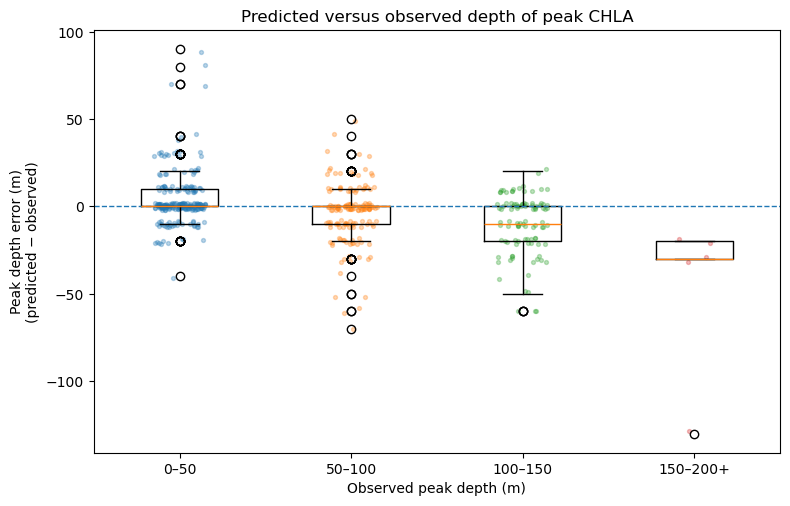

In [157]:
bins = [0, 50, 100, 150, 250]
labels = ["0–50", "50–100", "100–150", "150–200+"]

df_peaks = peak_df[["peak_obs_m", "peak_error_m"]].dropna().copy()
df_peaks["obs_bin"] = pd.cut(
    df_peaks["peak_obs_m"], bins=bins, labels=labels, right=False
)

data_for_box = [
    df_peaks.loc[df_peaks["obs_bin"] == lab, "peak_error_m"].to_numpy()
    for lab in labels
]

fig, ax = plt.subplots(figsize=(8, 5))

# Boxplot
ax.boxplot(data_for_box, vert=True)
ax.set_xticklabels(labels)
ax.set_xlabel("Observed peak depth (m)")
ax.set_ylabel("Peak depth error (m)\n(predicted − observed)")
ax.axhline(0, linestyle="--", linewidth=1)

# Jittered points per bin
x_jitter = 0.15  # half-width around each box position
y_jitter = 2  # half-width around each box position
for i, lab in enumerate(labels, start=1):  # box positions are 1..n
    vals = df_peaks.loc[df_peaks["obs_bin"] == lab, "peak_error_m"].to_numpy()
    if len(vals) == 0:
        continue
    x_vals = i + (np.random.rand(len(vals)) - 0.5) * 2 * x_jitter
    vals = vals + (np.random.rand(len(vals)) - 0.5) * 2 * y_jitter
    ax.scatter(x_vals, vals, s=8, alpha=0.3)

plt.tight_layout()
plt.title("Predicted versus observed depth of peak CHLA")
plt.show()


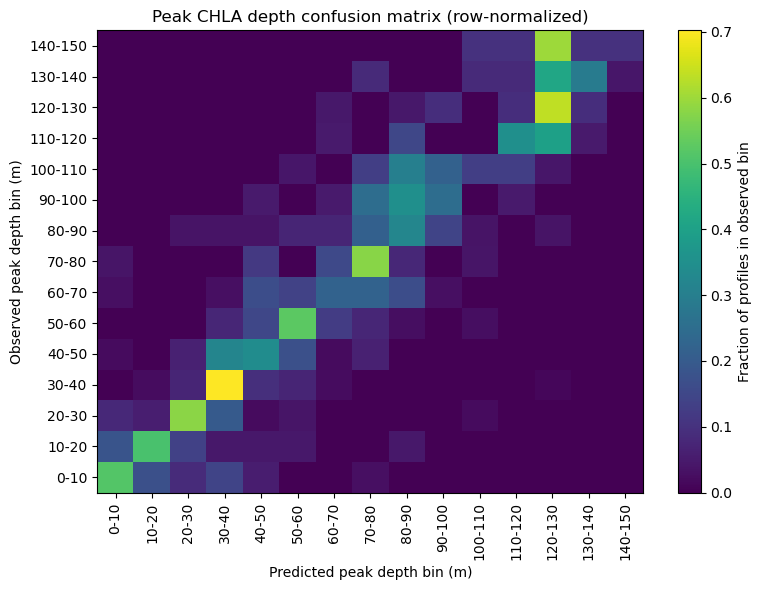

In [158]:
# confusion matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Work on a copy to avoid chained assignment warnings
dfc = peak_df[["peak_obs_m", "peak_pred_m"]].copy()

# Drop NaNs
dfc = dfc.dropna(subset=["peak_obs_m", "peak_pred_m"])

# Define 10 m bins from 0 to 200 m
bins = np.arange(0, 160, 10)  # 0,10,...,200
labels = [f"{b}-{b+10}" for b in bins[:-1]]

# Bin observed and predicted peak depths
dfc["obs_bin"] = pd.cut(dfc["peak_obs_m"], bins=bins, labels=labels, right=False)
dfc["pred_bin"] = pd.cut(dfc["peak_pred_m"], bins=bins, labels=labels, right=False)

# Remove any rows that fell outside bins
dfc = dfc.dropna(subset=["obs_bin", "pred_bin"])

# Raw confusion matrix (counts)
cm_counts = pd.crosstab(dfc["obs_bin"], dfc["pred_bin"])

# Row-normalized confusion matrix (fractions per observed bin)
cm_rownorm = cm_counts.div(cm_counts.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm_rownorm.values, origin="lower", aspect="auto")

# Tick labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted peak depth bin (m)")
ax.set_ylabel("Observed peak depth bin (m)")
ax.set_title("Peak CHLA depth confusion matrix (row-normalized)")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Fraction of profiles in observed bin")

plt.tight_layout()
plt.show()

### How big is the peak

We tend to underestimate the size of the peak by 25-40%.

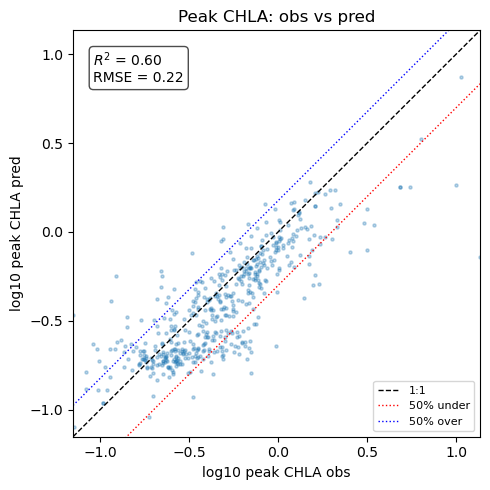

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Log10 and drop NaNs / non-finite
x = np.log10(peak_df["peak_obs_val"].to_numpy())
y = np.log10(peak_df["peak_pred_val"].to_numpy())

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# Metrics in log space (you could also do them in linear space if you prefer)
r2 = r2_score(x, y)
rmse = np.sqrt(mean_squared_error(x, y))

# Axis limits
xy_min = min(x.min(), y.min())
xy_max = max(x.max(), y.max())

# Lines for ±50%
offset_under = np.log10(0.5)   # ~ -0.301
offset_over  = np.log10(1.5)   # ~  0.176

xx = np.linspace(xy_min, xy_max, 100)

plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=5, alpha=0.3)

# 1:1 line
plt.plot(xx, xx, "k--", linewidth=1, label="1:1")

# 50% under- and over-prediction lines
plt.plot(xx, xx + offset_under, "r:", linewidth=1, label="50% under")
plt.plot(xx, xx + offset_over,  "b:", linewidth=1, label="50% over")

plt.xlim(xy_min, xy_max)
plt.ylim(xy_min, xy_max)

plt.xlabel("log10 peak CHLA obs")
plt.ylabel("log10 peak CHLA pred")
plt.title("Peak CHLA: obs vs pred")

# Annotate R² and RMSE
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}",
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
)

plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

### The total CHLA in the water column

Similarly we tend to underestimate the total amount in the water column by 25-40%.

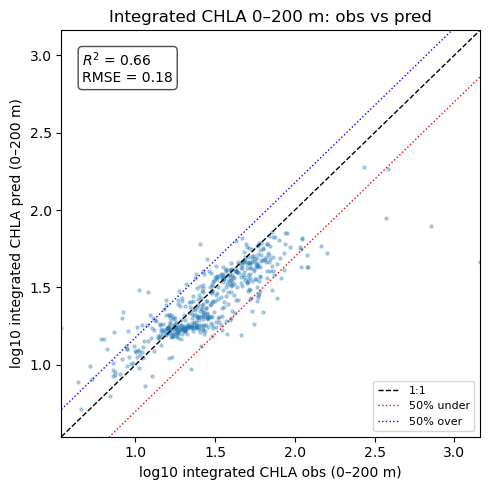

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Log10 and drop NaNs / non-finite
x = np.log10(peak_df["int_obs_0_200"].to_numpy())
y = np.log10(peak_df["int_pred_0_200"].to_numpy())

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# Metrics in log space (you could also do them in linear space if you prefer)
r2 = r2_score(x, y)
rmse = np.sqrt(mean_squared_error(x, y))

# Axis limits
xy_min = min(x.min(), y.min())
xy_max = max(x.max(), y.max())

# Lines for ±50%
offset_under = np.log10(0.5)   # ~ -0.301
offset_over  = np.log10(1.5)   # ~  0.176

xx = np.linspace(xy_min, xy_max, 100)

plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=5, alpha=0.3)

# 1:1 line
plt.plot(xx, xx, "k--", linewidth=1, label="1:1")

# 50% under- and over-prediction lines
plt.plot(xx, xx + offset_under, "r:", linewidth=1, label="50% under")
plt.plot(xx, xx + offset_over,  "b:", linewidth=1, label="50% over")

plt.xlim(xy_min, xy_max)
plt.ylim(xy_min, xy_max)

plt.xlabel("log10 integrated CHLA obs (0–200 m)")
plt.ylabel("log10 integrated CHLA pred (0–200 m)")
plt.title("Integrated CHLA 0–200 m: obs vs pred")

# Annotate R² and RMSE
plt.text(
    0.05, 0.95,
    f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}",
    transform=plt.gca().transAxes,
    va="top",
    ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
)

plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


## Summary

We have shown that we can predict CHLA depth profiles. `global_daily_netcdf.ipynb`

![](figures/pred_vs_obs_profiles.jpg)

### Next steps

* Use our model to process PACE Rrs data into daily global predictions.
* Match with Mixed Layer Depth to get how much of the CHLA is within the mixed layer depth and available to organisms.
  - Fraction of chlorophyll within the mixed layer
  - Depth of the chlorophyll maximum relative to the MLD
  - Chlorophyll-weighted mean depth vs MLD
  - CHLA above vs below a “foraging depth limit”

Why does the MLD matter? Some fish species that spend most of their time within the MLD: sardine & anchovy, juvenile salmon, mackerel, many forage fish. It has plankton, optimal light, stable temperature.